#Статья

##Постановка задачи

Данная работа эмулирует человеческий разговор, когда на реакцию влияет не только содержание слов, но и окружающая обстановка. Представленная в статье модель решает задачу предсказания следующей реплики, которая обусловлена историей диалога (0-2 реплики), стилем ответа (категориальная переменная, описывающая эмоцию говорящего) и изображением, задающим внешние условия, при которых происходит диалог.

##Датасет

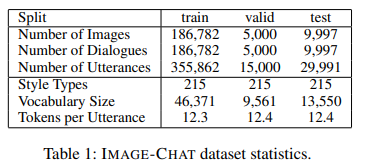

Идея для анализа: при обучении мы считаем верным продолжением лишь одну реплику, тогда как в датасете могут быть похожие по смыслу. В таком случае неправильно было бы считать их неверными продолжениями и процедуру обучения стоило бы скорректировать. Можно кластеризовать множество ответов, чтобы оценить их разнообразие и, как следствие, корректность обучения.

##Архитектура

Авторы статьи предлагают два варианта модели для решения поставленной задачи - *поисковую* и *генеративную*. Они имеют схожую архитектуру, отличающуюся выходами. Рассмотрим сначала их общие блоки.

На вход модель получает изображение, модальность (категориальное значение из 215 возможных вариантов) и предыдущую историю диалога (текст). Для каждой из трех частей входа есть подсеть, которая переводит ее в векторное представление.

**Изображение**

Для получения представления изображения используется предобученная модель ResNet. Авторы используют два ее варианта из библиотек pytorch:

https://pytorch.org/vision/stable/models.html - ResNet152

https://pytorch.org/hub/facebookresearch_WSL-Images_resnext/ - ResNeXt
32×48d

На вход этим моделям подается преобразованное некоторым образом (см.ссылку ниже) изображение, на выходе - вектор признаков. В случае поисковой модели мы пропускаем его через слой MLP с активацией RELU, в случае генеративной - через линейный слой. Размер выходного слоя - 500.

https://github.com/Oukey/M_L/blob/master/first_course/myML1_7.ipynb - tutorial по использованию предобученных моделей.

**Стиль**

Стиль - это категориальная переменная, для которой обучается эмбеддинг (слой https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). В случае поисковой модели выходная размерность 500, в случае генеративной - 300.

**История диалога**

Для кодирования диалога используют энкодер трансформера с 4 слоями, 6 головами attention и размерностью эмбеддинга 300 (выходной вектор). В модели используется трансформер, предобученный на задаче предсказания следующего предложения. 

Пример трансформера, где можно варьировать указанные параметры: https://d2l.ai/chapter_attention-mechanisms/transformer.html

Пайплайн обучения для этого предсказания выглядит следующим образом: вход - пара предложений, выход - 0/1 индикатор, что одно следует за другим. Датасет для обучения: https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/

Для первого и второго предложений обучаются два разных трансформера. Векторы, полученные с их помощью, сравниваются на близость с помощью скалярного произведения. Функция потерь - это отрицательное правдоподобие (https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) с использованием k-negative sampling (предполагаем, что имеется в виду k положительных и k отрицательных примера в батче).

Затем в Image2Chat используют второй из обученных трансформеров для кодирования истории диалога (веса инициализируются значениями, полученными при предобучении, затем дообучаются на исходной задаче). Эта подсеть далее будет обозначаться как D-трансформер.

**Дальнейшие блоки поисковой модели**

Итак, получены представления для составляющих входных данных. Это три вектора одинаковой размерности 500. Далее авторы предлагают различные способы их комбинации для представления примера целиком.

Есть два варианта это сделать: простой - взять сумму трех векторов, сложный - с использованием трансформера. Во втором векторы конкатенируются и пропускаются через трансформер со следующими гиперпараметрами: 2 слоя, 4 головы attention и размерность эмбеддинга 500. На выходе получаем вектор той же размерности, что были три входных.

Поисковая модель предсказывает лучшего кандидата из некоторой выборки, которым можно продолжить исходный диалог. Для этого требуется еще одна подсеть, которая переводит в вектор предложение-кандидата. Это трансформер с той же архитектурой, что и D-трансформер. Далее будет обозначаться как R-трансформер. При обучении его веса могут шариться с весами D-трансформера.  

Далее, когда получены вектор-комбинация из исходного примера и вектор-кандидат из R-трансформера, считается их похожесть вновь с помощью скалярного произведения. Для обучения поисковой модели авторы предлагают использовать мини-батч размера 500 и обучаться на отрицательное правдоподобие. Говоря подробнее, берутся 500 примеров (изображение, стиль, диалог) и 500 вариантов следующей реплики. Для подсчета функции потерь к вектору сходств кандидатов из батча применяется софтмакс.

**Дальнейшие блоки генеративной модели**

Генеративная модель использует декодер трансформера для генерации ответа. Входная последовательность для декодера состоит из векторов размера 300: в начале это эмбеддинг стиля, затем выходы D-трансформера, затем представление изображения. По этой последовательности стандартный декодер строит предложение-ответ.

##Метрики и эксперименты

**Бэйзлайн** 

Лучший кандидат - тот, что пересекается с исходным диалогов по наибольшему количеству слов

**Метрики**

Для каждого примера из тестовой выборки берется 100 кандидатов - верное продолжение и 99 рандомных (опять же из тестовой выборки). Кандидаты ранжируются по вероятностям, полученным с помощью описанной в предыдущем разделе модели.

*Метрика R@1* - recall для тех примеров, где истинный кандидат-продолжение первый в ранжированном в списке 

*Метрика R@5* - recall для тех примеров, где истинный кандидат-продолжение в топ-5 ранжированного списка

*ROUGE-L* (для генеративной модели) - длина наибольшей общей последовательности истинного и сгенерированного ответов, нормированная на длину истинного.

*BLEU-4* (формула на https://stackoverflow.com/questions/44324681/variation-in-bleu-score) - для обеих моделей, для сравнения с [Mostafazadeh et al (2017)](https://www.aclweb.org/anthology/I17-1047.pdf) (см.ниже)

**Список экспериментов**


*   Сравнение ResNet152 и ResNeXt 32×48d при предсказании всех реплик (результаты авторов 40.6% и 50.3% по метрике R@1 соответственно)
*   Сравнение ResNet152 и ResNeXt 32×48d при предсказании первой реплики (результаты авторов 34.5% и 54.0% по метрике R@1 соответственно). Из этого делают вывод, что ResNeXt 32×48d выделяет лучшее представление изображения, далее используют его.
*   Сравнение комбинирующей функции для представлений с использованием ResNet152 и ResNeXt 
*   Сравнение качества при совместном обучении весов D- и R- трансформеров и его отсутствии
*   Ablation: использование одной/двух/трех модальностей для предсказания каждой из трех реплик. Сравнение проводилось с ResNeXt 32×48d и отсутствием общих весов для поисковой и генеративной моделей.
*   Человеческая оценка: выбрать, какая реплика сгенерирована моделью, какая придумана человеком. Использовались ResNet152 и ResNeXt, генеративная и поисковая модель.
*   Сравнение с результатами близкой по тематике работы [Mostafazadeh et al (2017)](https://www.aclweb.org/anthology/I17-1047.pdf). В ней даются картинка и история диалога (2 реплики, вторая из них - вопрос). Нужно сгенерировать ответ на этот вопрос. Модели в открытом доступе нет, зато есть тестовый датасет (https://www.microsoft.com/en-us/download/details.aspx?id=55324&751be11f-ede8), и на нем можно снять те же метрики, что и в указанной работе (BLEU-4 и человеческая оценка). 